![title](walmart.jpeg)

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

# Initialization

### Import the different librairies

In [1]:
!pip install plotly -q
!pip install s3fs -q

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
from plotly.subplots import make_subplots
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

### 1. EDA

#### A. Basic statistics

In [125]:
walmart = pd.read_csv("Walmart_Store_sales.csv")

walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [126]:
walmart.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [127]:
# Basic stats
print("Number of rows : {}".format(walmart.shape[0]))
print()

print("Display of dataset: ")
display(walmart.head())
print()

print("Basics statistics: ")
data_desc = walmart.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*walmart.isnull().sum()/walmart.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [128]:
print(walmart.iloc[:,2].isnull() )
index_avec_nan = walmart.index[walmart.iloc[:,2].isnull()]
walmart.drop(index_avec_nan,0, inplace=True)

0      False
1      False
2       True
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Name: Weekly_Sales, Length: 150, dtype: bool


In [129]:
walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


In [130]:
# Conversion des valeurs de températures en °C => éviter des valeurs trop hautes
walmart['Temperature'] = ((walmart['Temperature'])-32)/1.8
walmart['Temperature']

0      15.338889
1       5.766667
3      29.205556
4      26.050000
5            NaN
         ...    
145    22.566667
146    -6.255556
147    13.966667
148    30.027778
149    12.888889
Name: Temperature, Length: 136, dtype: float64

In [131]:
walmart.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [132]:
walmart.shape

(136, 8)

In [133]:
from datetime import datetime

print('Number of lines remaining before treatment: ', walmart.shape[0])
walmart = walmart.dropna(subset=['Date'])
print('Number of lines remaining after treatment (dropna when no dates): ', walmart.shape[0])

Number of lines remaining before treatment:  136
Number of lines remaining after treatment (dropna when no dates):  118


In [134]:
walmart['Date'] = walmart['Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y')  )

walmart['Month'] =  walmart['Date'].apply(lambda x: x.strftime("%B") )

<ipython-input-134-252fe2377842>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-134-252fe2377842>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
# Separate target variable Y from features X
target_variable = 'Weekly_Sales'


Y = walmart.loc[:,target_variable]
print(Y.head())
print()

0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64



### B. Visualizing the data

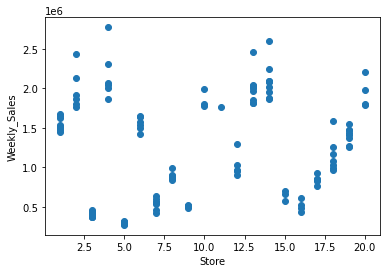

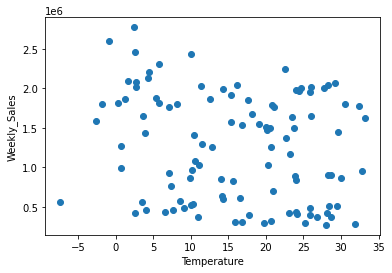

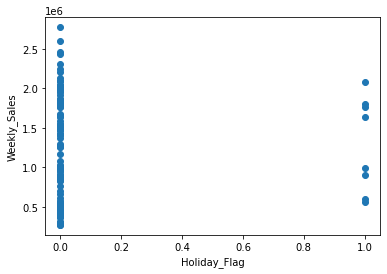

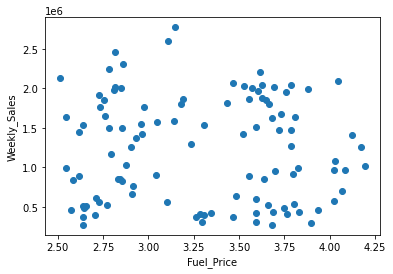

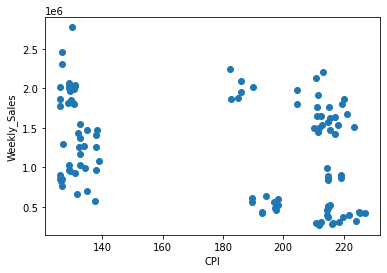

In [136]:
def scatter_visu(column):
    plt.scatter(x = walmart[column],y = walmart['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
    plt.show()
scatter_visu('Store')
scatter_visu('Temperature')
scatter_visu('Holiday_Flag')
scatter_visu('Fuel_Price')
scatter_visu('CPI')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



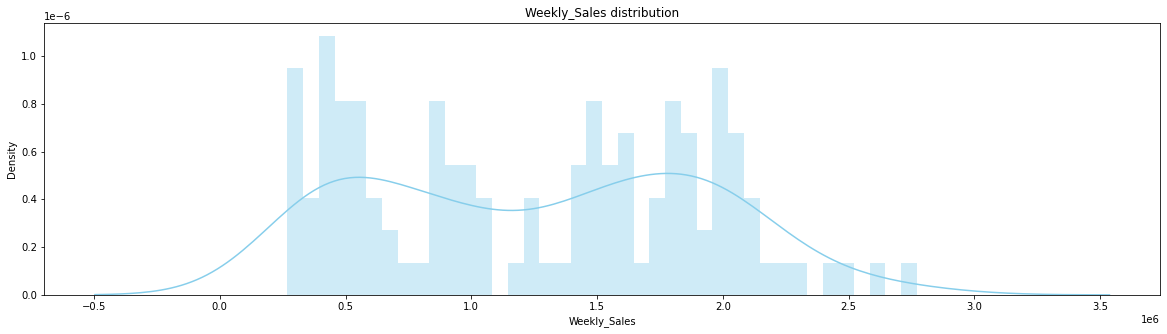

In [137]:
plt.figure(figsize=(20,5))
sns.distplot(walmart['Weekly_Sales'], bins=40, kde=True, color='skyblue')
plt.title('Weekly_Sales distribution')
plt.show();

In [138]:
px.histogram(walmart, x = walmart['Temperature'],y = walmart['Weekly_Sales'])    

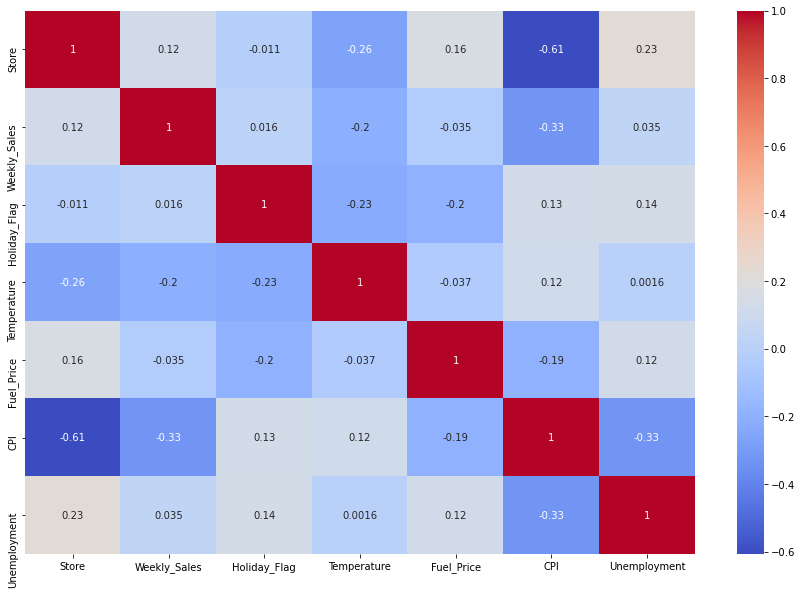

In [139]:
plt.figure(figsize= (15,10))
sns.heatmap(walmart.corr(), annot= True, cmap= 'coolwarm');

## We cannot necessarily notice that there are big correlations. But we can anticipate that the CPI will perhaps be important thereafter with a correlation of 60%. 

# C. Handling lines containing invalid values or outliers¶

In [140]:
# Now we will remove all the outliers in our dataframe
print('Nombre de ligne',walmart[:].shape [0])
mask = True
liste_col = ('Temperature','Fuel_Price','CPI')
for element in liste_col:
    borne_inf = walmart[element].mean() - 3*walmart[element].std()
    borne_sup = walmart[element].mean() + 3*walmart[element].std()
    mask = ((walmart[element] > borne_inf) | (walmart[element]) < borne_sup)
    walmart = walmart.loc[mask,:]
walmart.value_counts()

Nombre de ligne 118


Store  Date        Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  CPI         Unemployment  Month   
20.0   2012-02-03  2203523.20    0.0           4.405556     3.617       213.023623  6.961         February    1
4.0    2011-12-16  2771397.17    0.0           2.466667     3.149       129.898065  5.143         December    1
5.0    2011-05-13  290930.01     0.0           25.211111    3.899       216.534361  6.489         May         1
       2011-07-29  275142.17     0.0           31.900000    3.682       216.046436  6.529         July        1
       2011-11-11  311906.70     0.0           15.950000    3.297       218.569962  6.300         November    1
                                                                                                             ..
13.0   2012-06-01  2035431.39    0.0           16.172222    3.788       130.959226  5.965         June        1
14.0   2010-06-18  2248645.59    0.0           22.566667    2.780       182.442420  8.899         June       

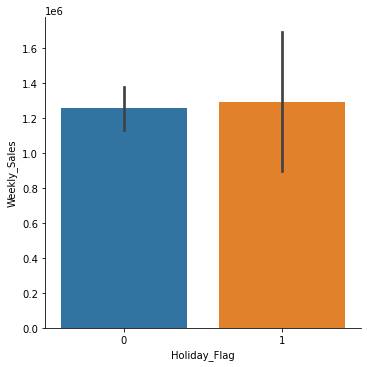

In [141]:
# On vérifie si en jour spécial, cela influe sur les ventes.

walmart['Holiday_Flag'] = walmart['Holiday_Flag'].apply(lambda x : 1 if x == 1 else 0)

sns.catplot(x= walmart['Holiday_Flag'], y = "Weekly_Sales", data = walmart, kind="bar")



In [142]:
walmart['Store'] = walmart['Store'].astype(int)
walmart['Store']

0       6
1      13
4       6
5       4
6      15
       ..
144     3
145    14
147    17
148     8
149    19
Name: Store, Length: 118, dtype: int64

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

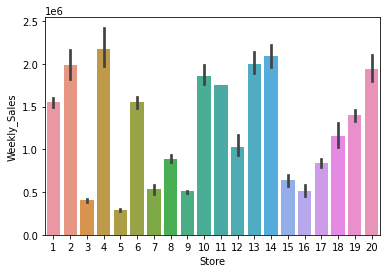

In [143]:
sns.barplot(data=walmart, x='Store', y='Weekly_Sales')

In [144]:
walmart['Store']

0       6
1      13
4       6
5       4
6      15
       ..
144     3
145    14
147    17
148     8
149    19
Name: Store, Length: 118, dtype: int64

In [145]:
walmart.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Month'],
      dtype='object')

# 2. Preprocessing & linear regression model

#### Firstly, we drop the lines where the date column is null and then create 2 columns :

- month in the year
- moment in the month

In [146]:

print('Number of lines remaining before treatment: ', walmart.shape[0])
walmart = walmart.dropna(subset=['Date'])
print('Number of lines remaining after treatment (dropna when no dates): ', walmart.shape[0])

Number of lines remaining before treatment:  118
Number of lines remaining after treatment (dropna when no dates):  118


### A. Separating the X and the Y

In [147]:
# Now we drop the Date column
walmart = walmart.drop('Date', axis=1)

#Now we'll going to preprocess our machine learning

# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = walmart.loc[:,target_name]
X = walmart.loc[:,[c for c in walmart.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0      6             0    15.338889       3.045  214.777523         6.858   
1     13             0     5.766667       3.435  128.616064         7.470   
4      6             0    26.050000       2.759  212.412888         7.092   
5      4             0          NaN       2.756  126.160226         7.896   
6     15             0    21.000000       4.069  134.855161         7.658   

      Month  
0  February  
1     March  
4       May  
5       May  
6      June  



In [148]:
# Divide dataset Train set & Test set 
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [149]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[7 0 10.333333333333334 3.804 197.5886046 8.09 'May']
 [13 0 24.633333333333333 2.85 nan 7.9510000000000005 'August']
 [20 0 23.983333333333334 2.8080000000000003 204.5675459 7.856 'June']
 [12 0 nan 4.087 129.0623548 13.735999999999999 'May']
 [7 1 -7.3388888888888895 3.103 196.91950559999998 8.256 'February']]
[[20 1 -1.7499999999999991 3.179 204.64322669999999 7.484 'December']
 [18 0 20.622222222222224 2.906 132.2939355 nan 'May']]

[532739.77, 1997397.63, 1973135.87, 964332.51, 563460.77]
[1799737.79, 1256282.79]


In [150]:
# Automatically detect positions of numeric/categorical features

# Create pipeline for numeric features
numeric_features = [2,3,4,5]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [0,1,6]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by the mean value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [151]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [152]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
X_train = X_train.todense()
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test)
X_test = X_test.todense()
# Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[7 0 10.333333333333334 3.804 197.5886046 8.09 'May']
 [13 0 24.633333333333333 2.85 nan 7.9510000000000005 'August']
 [20 0 23.983333333333334 2.8080000000000003 204.5675459 7.856 'June']
 [12 0 nan 4.087 129.0623548 13.735999999999999 'May']
 [7 1 -7.3388888888888895 3.103 196.91950559999998 8.256 'February']]
...Done.
[[-0.63873307  1.16941918  0.53029692  0.22096906  0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.        ]
 [ 0.85116175 -0.90723252  0.40751084  0.14043625  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.  

### B. First model : linear regression

In [153]:
# Train model
print("Train model...")
linear = LinearRegression()
linear.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


#### Prediction

In [154]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = linear.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = linear.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[ 531940.21104229 1981846.83937932 2003600.46185408  924591.17011936
  631150.20341501  446691.45949539 2087006.51050049  834605.8303444
  317432.49951742 2429747.09991975 1906376.44180582  823843.63670344
 2613895.75327703 1138974.36495969 1496124.47747069 1757242.51
  430383.80670428  948323.66785704 1484646.81415225 1801375.38437557
 2142320.70461655 1373324.50750577  822194.34579724 1572938.17744369
  893743.88920384  525271.88919922  431302.6798891  1576366.48055809
 1899341.22429093  516152.09316554 2066815.48341548  539319.71360571
  657009.83079876  491230.39987202 1113286.71448222 1845246.79221636
 1530009.57399117  284688.58988523 2054483.14597548 1400312.69294912
 1526302.15750921 1908263.11217044 1605246.18408049  521439.53978794
 1390319.99159045 2575011.82501503  559396.8796876   839878.09559645
 2045596.74734763  537804.34228935  444833.75012176  705643.19980616
  565114.64660635  315338.51422049  425316.12484303 2409229.83793582
 

In [155]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9901455538274847
R2 score on test set :  0.8991665820801145


#  
#### Le modèle est plutôt bon : pas de sur-apprentissage, et le score R2 est significativement bon. 
#### Voyons maintenant les coefficients

In [156]:
from sklearn.metrics import mean_squared_error

#The different coefficients
print ("\nThe coefficients:\n", linear.coef_,linear)
print('---')
# The mean squarred error
print ("\nThe Mean Squarred Error on test set:\n", mean_squared_error(Y_test, Y_test_pred))
print('It means that we predict the test Weekly_sales with a mean error of {} dollars '.format(int(mean_squared_error(Y_test, Y_test_pred)**0.5)))


The coefficients:
 [-3.53993179e+03 -1.29813640e+04  2.64913322e+03 -1.16267375e+05
  3.93200158e+05 -1.15040170e+06  4.01664194e+05 -1.32155976e+06
 -8.15407716e+03 -9.37308241e+05 -7.26112156e+05 -1.10862469e+06
  3.92516995e+05  1.48006792e+05 -1.49313462e+05  4.25944061e+05
  5.94502340e+05 -8.60362594e+05 -1.01677381e+06 -7.34371981e+05
 -3.21301278e+05 -5.50315549e+04  4.60271903e+05  4.37250737e+04
  7.03152613e+04  5.03178651e+05  5.47689146e+04 -8.56813636e+04
  1.66642237e+04  4.91131530e+04 -3.06337582e+04  1.43826430e+04
  4.77661421e+04  4.69947109e+02 -5.51243994e+04] LinearRegression()
---

The Mean Squarred Error on test set:
 31515966966.92596
It means that we predict the test Weekly_sales with a mean error of 177527 dollars 


In [157]:
features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
features
numeric = ['Temperature','Fuel_Price','CPI','Unemployment']
Z = features + numeric
Z = pd.DataFrame(Z, columns=['features'])
coef = pd.DataFrame(linear.coef_,columns=['coefficient'])
coeff = pd.concat([Z,coef],axis=1)
coeff.groupby(['coefficient']).sort
coeff

,features,coefficient
0,x0_2,-3.539932e+03
1,x0_3,-1.298136e+04
2,x0_4,2.649133e+03
3,x0_5,-1.162674e+05
4,x0_6,3.932002e+05
5,x0_7,-1.150402e+06
6,x0_8,4.016642e+05
7,x0_9,-1.321560e+06
8,x0_10,-8.154077e+03
9,x0_11,-9.373082e+05


In [158]:
coef_num = pd.DataFrame(index = Z, data = { 'coefficients' : linear.coef_[:],
                                                  #‘pvalues’ : ols_fit.pvalues[1:5] }
                                                }).sort_values('coefficients')

coef_num.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=False)

,coefficients
"(x0_9,)",1.321560e+06
"(x0_7,)",1.150402e+06
"(x0_13,)",1.108625e+06
"(x0_20,)",1.016774e+06
"(x0_11,)",9.373082e+05
"(x0_19,)",8.603626e+05
"(x1_1,)",7.343720e+05
"(x0_12,)",7.261122e+05
"(x0_18,)",5.945023e+05
"(x2_June,)",5.031787e+05


In [159]:
coef_num = pd.DataFrame(index =numeric, data = { 'coefficients' : linear.coef_[0:4]}).sort_values("coefficients")
coef_num

,coefficients
Unemployment,-116267.375176
Fuel_Price,-12981.363961
Temperature,-3539.931790
CPI,2649.133221


In [160]:
coef_cat = pd.DataFrame(index =features, data = { 'coefficients' : linear.coef_[4:35],}).sort_values(by = "coefficients")
df3 = pd.concat([coef_num,coef_cat])
coef_cat

,coefficients
x0_5,-1.321560e+06
x0_3,-1.150402e+06
x0_9,-1.108625e+06
x0_16,-1.016774e+06
x0_7,-9.373082e+05
x0_15,-8.603626e+05
x0_17,-7.343720e+05
x0_8,-7.261122e+05
x0_18,-3.213013e+05
x0_12,-1.493135e+05


Thanks to the coefficients, we can see some variables usefully positive to our prediction, compare to some others variables that they are negative.

### Ridge

In [161]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=4)
#scores = cross_val_score(regressor, X_train, Y_train, cv=5)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.8578952382853637
The standard deviation is :  0.02782653983051493


In [162]:
# Perform grid search
print("Grid search...")
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.00001, 0.001, 0.1, 0.2, 0.5, 1.0, 10, 100] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 6) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.001}
Best R2 score :  0.9723445501929362


In [164]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_ridge_pred = gridsearch.predict(X_train)
print("...Done.")
#print(Y_train_pred)
#print()

# Predictions on test set
print("Predictions on test set...")
Y_test_ridge_pred = gridsearch.predict(X_test)
print("...Done.")
#print(Y_test_pred)
#print()

# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("Best R2 score on training set (Linear Regression): ", r2_score(Y_train, Y_train_pred))
print("Best R2 score on test set (Linear Regression): ", r2_score(Y_test, Y_test_pred))
print ("\nThe Mean Squarred Error on test set:\n", mean_squared_error(Y_test, Y_test_ridge_pred))
print('It means that we predict the test Weekly_sales with a mean error of {} dollars '.format(int(mean_squared_error(Y_test, Y_test_ridge_pred)**0.5)))

Predictions on training set...
...Done.
Predictions on test set...
...Done.
Best R2 score on training set (Linear Regression):  0.9901455538274847
Best R2 score on test set (Linear Regression):  0.8991665820801145

The Mean Squarred Error on test set:
 31556001326.76538
It means that we predict the test Weekly_sales with a mean error of 177640 dollars 


#### Nous pouvons conclure que la donnée la plus impactante est le 'Store'. En effet, changer de magasin peut changer le résultat avec un coeff élevé.
#### Mais si on regarde le coeff du mois par exemple, décembre est un assez bon accélérateur de business.

## 

### On peut voir que le modèle Ridge n'est pas plus forcément haut que notre premier modèle. Si nous regardons nos R2 et MSE, ils étaient meilleurs que le Ridge, donc nous pouvons garder le premier modèle.